In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

cities_all=['Berlin','Dresden','Düsseldorf','Frankfurt am Main','Kassel','Leipzig','Magdeburg','Potsdam','Clermont','Dijon','Lille','Lyon','Montpellier','Nantes','Nimes','Paris','Toulouse','Madrid','Wien']

In [2]:
city='Berlin'
df=pd.read_csv('../outputs/summary_stats/Berlin_stats.csv')
df['City']=city
df_all=df.copy()

for city in ['Dresden','Düsseldorf','Frankfurt am Main','Kassel','Leipzig','Magdeburg','Potsdam','Clermont','Dijon','Lille','Lyon','Montpellier','Nantes','Nimes','Paris','Toulouse','Madrid','Wien']:
    df=pd.read_csv('../outputs/summary_stats/' + city + '_stats.csv')
    df['City']=city
    df_all=pd.concat([df_all,df])
df_all

,Mode,Daily_Travel_cap,Mode_Share,Ownership,Daily_travel_all,City
0,2_3_Wheel,0.169473,0.009567,NaN,NaN,Berlin
1,Bike,2.204074,0.124421,NaN,NaN,Berlin
2,Car,6.970883,0.393511,0.567244,NaN,Berlin
3,Foot,0.925913,0.052268,NaN,NaN,Berlin
4,Transit,7.444241,0.420232,NaN,NaN,Berlin
...,...,...,...,...,...,...
1,Bike,0.405803,0.018406,NaN,NaN,Wien
2,Car,10.389040,0.471215,0.753439,NaN,Wien
3,Foot,0.856306,0.038839,NaN,NaN,Wien
4,Transit,10.242574,0.464572,NaN,NaN,Wien


In [3]:
# convert to %
df_all['Mode_Share']=df_all['Mode_Share']*100

In [4]:
summ_UF=pd.read_csv('../outputs/summary_stats/summary_UF_all.csv')
summ_UF.rename(columns={'cities':'City'},inplace=True)
summ_UF['Pop.']=summ_UF['Population'].replace(',','',regex=True).astype(int)*1e-6
summ_UF

,City,Population,Area,Pop. density,Built-up density,Dist. to center,Dist. to subcenter,Instersec. density,Street length avg.,Cycle lane share,Urban fabric area,Commercial area,Unnamed: 12,Unnamed: 13,Pop.
0,Berlin,"3,303,002",896,3687,1.10,8.50,2.45,23.65,144.0,5%,25%,10%,NaN,3.303,3.303002
1,Dresden,"512,829",328,1562,0.54,4.73,2.93,18.02,140.3,9%,14%,7%,NaN,0.513,0.512829
2,Düsseldorf,"586,399",215,2724,1.07,4.34,2.50,27.54,116.9,9%,20%,14%,NaN,0.586,0.586399
3,Frankfurt am Main,"704,016",253,2785,0.30,4.86,2.16,27.64,121.4,17%,12%,12%,NaN,0.704,0.704016
4,Kassel,"190,786",108,1765,0.14,3.16,2.75,25.58,124.9,4%,19%,9%,NaN,0.191,0.190786
5,Leipzig,"503,235",298,1689,0.74,4.43,2.61,20.96,130.2,8%,13%,12%,NaN,0.503,0.503235
6,Magdeburg,"228,201",202,1131,0.63,2.94,1.73,15.54,145.3,5%,10%,8%,NaN,0.228,0.228201
7,Potsdam,"155,925",188,828,0.26,4.15,2.27,10.61,147.2,5%,5%,3%,NaN,0.156,0.155925
8,Clermont,"284,830",311,915,0.45,3.99,2.73,25.31,97.5,3%,12%,8%,NaN,0.285,0.284830
9,Dijon,"253,637",241,1052,0.40,2.90,2.68,21.70,105.9,3%,8%,8%,NaN,0.254,0.253637


In [5]:
df_all=df_all.merge(summ_UF.loc[:,['City','Population','Pop. density','Pop.']])
df_all

,Mode,Daily_Travel_cap,Mode_Share,Ownership,Daily_travel_all,City,Population,Pop. density,Pop.
0,2_3_Wheel,0.169473,0.956685,NaN,NaN,Berlin,"3,303,002",3687,3.303002
1,Bike,2.204074,12.442144,NaN,NaN,Berlin,"3,303,002",3687,3.303002
2,Car,6.970883,39.351096,0.567244,NaN,Berlin,"3,303,002",3687,3.303002
3,Foot,0.925913,5.226840,NaN,NaN,Berlin,"3,303,002",3687,3.303002
4,Transit,7.444241,42.023236,NaN,NaN,Berlin,"3,303,002",3687,3.303002
...,...,...,...,...,...,...,...,...,...
99,Bike,0.405803,1.840597,NaN,NaN,Wien,"1,871,960",2185,1.871960
100,Car,10.389040,47.121502,0.753439,NaN,Wien,"1,871,960",2185,1.871960
101,Foot,0.856306,3.883943,NaN,NaN,Wien,"1,871,960",2185,1.871960
102,Transit,10.242574,46.457176,NaN,NaN,Wien,"1,871,960",2185,1.871960


In [6]:
df_all.sort_values(by='Pop. density',ascending=False,inplace=True)
df_all

,Mode,Daily_Travel_cap,Mode_Share,Ownership,Daily_travel_all,City,Population,Pop. density,Pop.
87,Transit,7.085119,52.282223,NaN,NaN,Paris,"6,941,530",8514,6.941530
83,2_3_Wheel,0.365380,2.696200,NaN,NaN,Paris,"6,941,530",8514,6.941530
84,Bike,0.142129,1.048791,NaN,NaN,Paris,"6,941,530",8514,6.941530
85,Car,5.255074,38.778025,0.678733,NaN,Paris,"6,941,530",8514,6.941530
86,Foot,0.703977,5.194760,NaN,NaN,Paris,"6,941,530",8514,6.941530
...,...,...,...,...,...,...,...,...,...
46,Transit,5.479417,33.462739,NaN,NaN,Potsdam,"155,925",828,0.155925
45,Foot,0.698697,4.266938,NaN,NaN,Potsdam,"155,925",828,0.155925
44,Car,7.948624,48.542155,0.674408,NaN,Potsdam,"155,925",828,0.155925
43,Bike,2.219062,13.551789,NaN,NaN,Potsdam,"155,925",828,0.155925


In [7]:
df_mode=df_all.loc[:,['City','Pop. density','Mode_Share','Mode']]
#df_mode=df_all.drop(columns=['Daily_Travel_cap','Pop.','Area','Pop. Density'])

In [8]:
df_plot=pd.pivot(df_mode,index='City',columns='Mode',values='Mode_Share').reset_index()
df_plot=df_plot.merge(df_all.loc[:,['City','Pop. density']])
df_plot.sort_values(by='Pop. density',ascending=False,inplace=True)
df_plot.drop(columns='Pop. density',inplace=True)
df_plot.drop_duplicates(inplace=True)
df_plot.rename(columns={'2_3_Wheel':'2/3 Wheel'}, inplace=True)
df_plot

,City,2/3 Wheel,All,Bike,Car,Foot,Transit
82,Paris,2.696200,NaN,1.048791,38.778025,5.194760,52.282223
60,Madrid,1.284193,NaN,0.262328,54.803366,4.637233,39.012880
0,Berlin,0.956685,NaN,12.442144,39.351096,5.226840,42.023236
33,Frankfurt am Main,1.392019,NaN,12.892853,53.579208,5.500021,26.635899
22,Düsseldorf,0.750340,NaN,10.861446,56.248817,5.514516,26.624881
51,Lyon,0.975108,NaN,1.071363,63.847244,6.097536,28.008748
103,Wien,0.696782,NaN,1.840597,47.121502,3.883943,46.457176
47,Lille,0.398467,NaN,0.919410,77.705906,4.856673,16.119543
35,Kassel,0.365961,NaN,9.978454,59.347146,8.293817,22.014622
40,Leipzig,0.843822,NaN,14.062421,56.643452,6.265161,22.185144


In [9]:
df_plot=df_plot.loc[:,['City','Car','2/3 Wheel','Transit','Bike','Foot']]
df_plot

,City,Car,2/3 Wheel,Transit,Bike,Foot
82,Paris,38.778025,2.696200,52.282223,1.048791,5.194760
60,Madrid,54.803366,1.284193,39.012880,0.262328,4.637233
0,Berlin,39.351096,0.956685,42.023236,12.442144,5.226840
33,Frankfurt am Main,53.579208,1.392019,26.635899,12.892853,5.500021
22,Düsseldorf,56.248817,0.750340,26.624881,10.861446,5.514516
51,Lyon,63.847244,0.975108,28.008748,1.071363,6.097536
103,Wien,47.121502,0.696782,46.457176,1.840597,3.883943
47,Lille,77.705906,0.398467,16.119543,0.919410,4.856673
35,Kassel,59.347146,0.365961,22.014622,9.978454,8.293817
40,Leipzig,56.643452,0.843822,22.185144,14.062421,6.265161


In [10]:
df_comp=df_plot.merge(summ_UF.loc[:,['City','Population','Pop. density']])
df_comp

,City,Car,2/3 Wheel,Transit,Bike,Foot,Population,Pop. density
0,Paris,38.778025,2.696200,52.282223,1.048791,5.194760,"6,941,530",8514
1,Madrid,54.803366,1.284193,39.012880,0.262328,4.637233,"5,279,092",3902
2,Berlin,39.351096,0.956685,42.023236,12.442144,5.226840,"3,303,002",3687
3,Frankfurt am Main,53.579208,1.392019,26.635899,12.892853,5.500021,"704,016",2785
4,Düsseldorf,56.248817,0.750340,26.624881,10.861446,5.514516,"586,399",2724
5,Lyon,63.847244,0.975108,28.008748,1.071363,6.097536,"1,382,539",2517
6,Wien,47.121502,0.696782,46.457176,1.840597,3.883943,"1,871,960",2185
7,Lille,77.705906,0.398467,16.119543,0.919410,4.856673,"1,140,053",1859
8,Kassel,59.347146,0.365961,22.014622,9.978454,8.293817,"190,786",1765
9,Leipzig,56.643452,0.843822,22.185144,14.062421,6.265161,"503,235",1689


In [11]:
df_comp[['Transit','Car','Foot','Population','Pop. density']].corr()

,Transit,Car,Foot,Pop. density
Transit,1.000000,-0.893488,-0.393751,0.768455
Car,-0.893488,1.000000,0.178003,-0.644344
Foot,-0.393751,0.178003,1.000000,-0.136763
Pop. density,0.768455,-0.644344,-0.136763,1.000000


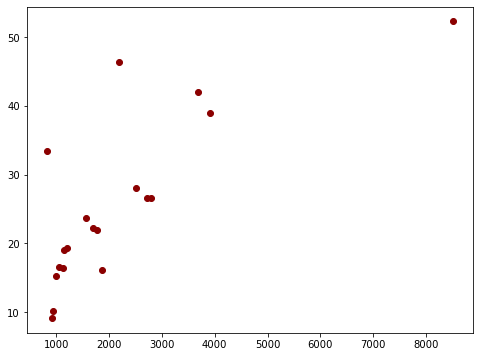

In [12]:
fig, ax = plt.subplots(figsize=(8,6))
c='darkred'
#ax.plot(df_comp['Pop. Density'],df_comp['Transit'],color=c,type='scatter')
ax.scatter(df_comp['Pop. density'],df_comp['Transit'], color=c)

In [13]:
# summ_UF['Pop.']=summ_UF['Population'].replace(',','',regex=True).astype(int)*1e-6

In [14]:
size_sort_pop=summ_UF.sort_values(by='Pop.',ascending=False).reset_index(drop=True)
size_sort_pop

,City,Population,Area,Pop. density,Built-up density,Dist. to center,Dist. to subcenter,Instersec. density,Street length avg.,Cycle lane share,Urban fabric area,Commercial area,Unnamed: 12,Unnamed: 13,Pop.
0,Paris,"6,941,530",815,8514,2.27,8.66,3.46,56.86,101.0,15%,30%,17%,NaN,6.942,6.941530
1,Madrid,"5,279,092",1353,3902,0.98,9.41,2.42,31.66,104.1,1%,11%,12%,NaN,5.279,5.279092
2,Berlin,"3,303,002",896,3687,1.10,8.50,2.45,23.65,144.0,5%,25%,10%,NaN,3.303,3.303002
3,Wien,"1,871,960",857,2185,1.10,6.47,3.30,19.67,132.5,3%,14%,7%,NaN,1.872,1.871960
4,Lyon,"1,382,539",549,2517,0.97,5.71,3.12,32.22,113.9,7%,23%,12%,NaN,1.383,1.382539
5,Lille,"1,140,053",613,1859,0.71,7.14,2.47,33.69,102.4,8%,22%,12%,NaN,1.140,1.140053
6,Toulouse,"890,843",781,1140,0.52,6.20,3.30,27.58,102.5,5%,22%,9%,NaN,0.891,0.890843
7,Frankfurt am Main,"704,016",253,2785,0.30,4.86,2.16,27.64,121.4,17%,12%,12%,NaN,0.704,0.704016
8,Nantes,"646,521",535,1208,0.47,4.89,2.69,27.68,99.4,17%,16%,9%,NaN,0.647,0.646521
9,Düsseldorf,"586,399",215,2724,1.07,4.34,2.50,27.54,116.9,9%,20%,14%,NaN,0.586,0.586399


In [15]:
size_sort_dens=summ_UF.sort_values(by='Pop. density',ascending=False).reset_index(drop=True)
size_sort_dens

,City,Population,Area,Pop. density,Built-up density,Dist. to center,Dist. to subcenter,Instersec. density,Street length avg.,Cycle lane share,Urban fabric area,Commercial area,Unnamed: 12,Unnamed: 13,Pop.
0,Paris,"6,941,530",815,8514,2.27,8.66,3.46,56.86,101.0,15%,30%,17%,NaN,6.942,6.941530
1,Madrid,"5,279,092",1353,3902,0.98,9.41,2.42,31.66,104.1,1%,11%,12%,NaN,5.279,5.279092
2,Berlin,"3,303,002",896,3687,1.10,8.50,2.45,23.65,144.0,5%,25%,10%,NaN,3.303,3.303002
3,Frankfurt am Main,"704,016",253,2785,0.30,4.86,2.16,27.64,121.4,17%,12%,12%,NaN,0.704,0.704016
4,Düsseldorf,"586,399",215,2724,1.07,4.34,2.50,27.54,116.9,9%,20%,14%,NaN,0.586,0.586399
5,Lyon,"1,382,539",549,2517,0.97,5.71,3.12,32.22,113.9,7%,23%,12%,NaN,1.383,1.382539
6,Wien,"1,871,960",857,2185,1.10,6.47,3.30,19.67,132.5,3%,14%,7%,NaN,1.872,1.871960
7,Lille,"1,140,053",613,1859,0.71,7.14,2.47,33.69,102.4,8%,22%,12%,NaN,1.140,1.140053
8,Kassel,"190,786",108,1765,0.14,3.16,2.75,25.58,124.9,4%,19%,9%,NaN,0.191,0.190786
9,Leipzig,"503,235",298,1689,0.74,4.43,2.61,20.96,130.2,8%,13%,12%,NaN,0.503,0.503235


In [16]:
xt = np.array(range(0, 19))

In [17]:
df_mode

,City,Pop. density,Mode_Share,Mode
87,Paris,8514,52.282223,Transit
83,Paris,8514,2.696200,2_3_Wheel
84,Paris,8514,1.048791,Bike
85,Paris,8514,38.778025,Car
86,Paris,8514,5.194760,Foot
...,...,...,...,...
46,Potsdam,828,33.462739,Transit
45,Potsdam,828,4.266938,Foot
44,Potsdam,828,48.542155,Car
43,Potsdam,828,13.551789,Bike


In [22]:
df_plot2=pd.pivot(df_mode,index='City',columns='Mode',values='Mode_Share').reset_index()
df_plot2=df_plot2.merge(df_all.loc[:,['City','Pop.']])
df_plot2.sort_values(by='Pop.',ascending=False,inplace=True)
df_plot2.drop(columns=['Pop.','All'],inplace=True)
df_plot2.drop_duplicates(inplace=True)
df_plot2

,City,2_3_Wheel,Bike,Car,Foot,Transit
86,Paris,2.696200,1.048791,38.778025,5.194760,52.282223
56,Madrid,1.284193,0.262328,54.803366,4.637233,39.012880
0,Berlin,0.956685,12.442144,39.351096,5.226840,42.023236
99,Wien,0.696782,1.840597,47.121502,3.883943,46.457176
52,Lyon,0.975108,1.071363,63.847244,6.097536,28.008748
49,Lille,0.398467,0.919410,77.705906,4.856673,16.119543
93,Toulouse,1.597649,1.322016,74.775399,3.299319,19.005616
32,Frankfurt am Main,1.392019,12.892853,53.579208,5.500021,26.635899
76,Nantes,1.179612,1.576961,73.496416,4.387194,19.359817
23,Düsseldorf,0.750340,10.861446,56.248817,5.514516,26.624881


C:\Users\peter\AppData\Local\Temp\ipykernel_352\981983360.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(size_sort_dens['City'].values)


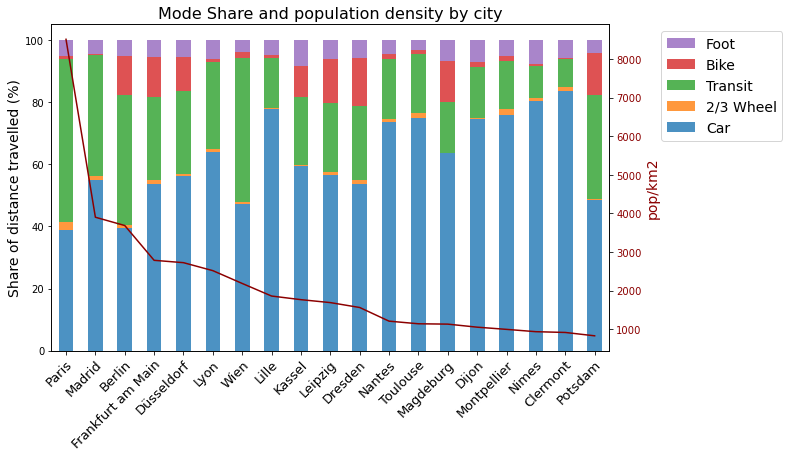

In [19]:
fig, ax1 = plt.subplots(figsize=(10,6))
df_plot.plot(kind='bar', stacked=True,ax=ax1,alpha=0.8)
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[::-1], labels[::-1],bbox_to_anchor=(1.08, 1.0),fontsize=14)
ax1.set_xticklabels(df_plot['City'].values)
plt.xticks(rotation = 45,fontsize=13,ha='right',rotation_mode='anchor')
#plt.xlabel('Distance Bands (km)',fontsize=12)
plt.ylabel('Share of distance travelled (%)',fontsize=14)
plt.title('Mode Share and population density by city',fontsize=16)

ax2 = ax1.twinx() 
c='darkred'
ax2.plot(size_sort_dens['City'],size_sort_dens['Pop. density'],color=c)
ax2.set_ylabel('pop/km2', color=c,fontsize=14)
ax2.set_xticklabels(size_sort_dens['City'].values)
ax2.xaxis.set_major_locator(mticker.FixedLocator(xt))
ax2.tick_params(axis='y', labelcolor=c)

plt.savefig('../figures/summary_all/mode_density_bar.png',facecolor='w',dpi=65,bbox_inches='tight')


C:\Users\peter\AppData\Local\Temp\ipykernel_352\1264331868.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(size_sort_pop['City'].values)


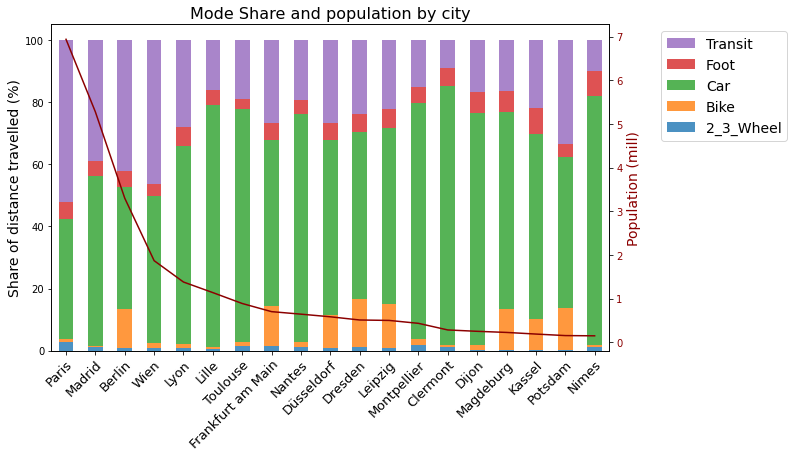

In [23]:
fig, ax1 = plt.subplots(figsize=(10,6))
df_plot2.plot(kind='bar', stacked=True,ax=ax1,alpha=0.8)
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[::-1], labels[::-1],bbox_to_anchor=(1.08, 1.0),fontsize=14)
ax1.set_xticklabels(df_plot2['City'].values)
plt.xticks(rotation = 45,fontsize=13,ha='right',rotation_mode='anchor')
plt.ylabel('Share of distance travelled (%)',fontsize=14)
plt.title('Mode Share and population by city',fontsize=16)

ax2 = ax1.twinx() 
c='darkred'
ax2.plot(size_sort_pop['City'],size_sort_pop['Pop.'],color=c)
ax2.set_ylabel('Population (mill)', color=c,fontsize=14)
ax2.set_xticklabels(size_sort_pop['City'].values)
ax2.xaxis.set_major_locator(mticker.FixedLocator(xt))
ax2.tick_params(axis='y', labelcolor=c)
plt.savefig('../figures/summary_all/mode_pop_bar.png',facecolor='w',dpi=65,bbox_inches='tight')

In [ ]:
sHP['Adult']=0
sHP['Child']=0
sHP.loc[sHP['Age']>17,'Adult']=1
sHP.loc[sHP['Age']<18,'Child']=1

Nadult=sHP.loc[:,['HHNR','Adult']].groupby('HHNR')['Adult'].sum().reset_index()
Nadult.rename(columns={'Adult':'N_Adult_HH'},inplace=True)
Nchild=sHP.loc[:,['HHNR','Child']].groupby('HHNR')['Child'].sum().reset_index()
Nchild.rename(columns={'Child':'N_Child_HH'},inplace=True)
sHP=sHP.merge(Nadult)
sHP=sHP.merge(Nchild)

In [ ]:
ages=sHP.loc[:,['HHNR','Age']].groupby('HHNR')['Age'].describe().reset_index() 
ages=ages.loc[:,['HHNR','min','max']]
ages.rename(columns={'min':'minAgeHH','max':'maxAgeHH'},inplace=True)
sHP=sHP.merge(ages)

In [ ]:
sHP['HHType_simp']='Blank'
sHP.loc[(sHP['HHSize']==1) &  (sHP['Sex']==1), 'HHType_simp']='Single_Male'
sHP.loc[(sHP['HHSize']==1) & (sHP['Sex']==2), 'HHType_simp']='Single_Female'

sHP.loc[(sHP['N_Adult_HH']==1) & (sHP['N_Child_HH']>0) & (sHP['Age']>17) & (sHP['Sex']==1), 'HHType_simp']='Single_Male_Parent' 
sHP.loc[(sHP['N_Adult_HH']==1) & (sHP['N_Child_HH']>0) & (sHP['Age']>17) & (sHP['Sex']==2), 'HHType_simp']='Single_Female_Parent'

sHP.loc[(sHP['N_Adult_HH']>1) & (sHP['N_Child_HH']>0), 'HHType_simp']='MultiAdult_Kids'

sHP.loc[(sHP['N_Adult_HH']>1) & (sHP['N_Child_HH']==0) , 'HHType_simp']='MultiAdult'

# fill in the type for kids in single parent households
for hh in sHP.loc[sHP['HHType_simp']=='Blank','HHNR']:
    if 'Single_Male_Parent' in sHP.loc[sHP['HHNR']==hh,'HHType_simp'].values:
        sHP.loc[sHP['HHNR']==hh,'HHType_simp']='Single_Male_Parent'
    if 'Single_Female_Parent' in sHP.loc[sHP['HHNR']==hh,'HHType_simp'].values:
        sHP.loc[sHP['HHNR']==hh,'HHType_simp']='Single_Female_Parent'

sHP['HHType_simp'].value_counts()

MultiAdult_Kids         2234
MultiAdult              2156
Single_Female            542
Single_Male              427
Single_Female_Parent     170
Single_Male_Parent        48
Name: HHType_simp, dtype: int64

In [ ]:
sHP['HHType_det']='Blank'
sHP.loc[(sHP['N_Adult_HH']==1) & (sHP['N_Child_HH']==0) & (sHP['Sex']==1) & (sHP['Age']<40), 'HHType_det']='Single_Male_Under40'
sHP.loc[(sHP['N_Adult_HH']==1) & (sHP['N_Child_HH']==0) & (sHP['Sex']==2) & (sHP['Age']<40), 'HHType_det']='Single_Female_Under40'

sHP.loc[(sHP['N_Adult_HH']==1) & (sHP['N_Child_HH']==0) & (sHP['Sex']==1) & (sHP['Age']>39) & (sHP['Age']<65), 'HHType_det']='Single_Male_40-64'
sHP.loc[(sHP['N_Adult_HH']==1) & (sHP['N_Child_HH']==0) & (sHP['Sex']==2) & (sHP['Age']>39) & (sHP['Age']<65), 'HHType_det']='Single_Female_40-64'

sHP.loc[(sHP['N_Adult_HH']==1) & (sHP['N_Child_HH']==0) & (sHP['Sex']==1) & (sHP['Age']>64), 'HHType_det']='Single_Male_>64'
sHP.loc[(sHP['N_Adult_HH']==1) & (sHP['N_Child_HH']==0) & (sHP['Sex']==2) & (sHP['Age']>64), 'HHType_det']='Single_Female_>64'

sHP.loc[(sHP['N_Adult_HH']==1) & (sHP['N_Child_HH']>0) & (sHP['Age']>17) & (sHP['Sex']==1), 'HHType_det']='Single_Male_Parent' 
sHP.loc[(sHP['N_Adult_HH']==1) & (sHP['N_Child_HH']>0) & (sHP['Age']>17) & (sHP['Sex']==2), 'HHType_det']='Single_Female_Parent'

sHP.loc[(sHP['N_Adult_HH']>1) & (sHP['N_Child_HH']>0), 'HHType_det']='MultiAdult_Kids'

sHP.loc[(sHP['N_Adult_HH']>1) & (sHP['N_Child_HH']==0) & (sHP['minAgeHH']>64), 'HHType_det']='MultiAdult_>65'
sHP.loc[(sHP['N_Adult_HH']>1) & (sHP['N_Child_HH']==0) & (sHP['maxAgeHH']<65), 'HHType_det']='MultiAdult_Under65'
sHP.loc[(sHP['N_Adult_HH']>1) & (sHP['N_Child_HH']==0) & (sHP['minAgeHH']<65) & (sHP['maxAgeHH']>64), 'HHType_det']='MultiAdult_MixGen'

# fill in the type for kids in single parent households
for hh in sHP.loc[sHP['HHType_det']=='Blank','HHNR']:
    if 'Single_Male_Parent' in sHP.loc[sHP['HHNR']==hh,'HHType_det'].values:
        sHP.loc[sHP['HHNR']==hh,'HHType_det']='Single_Male_Parent'
    if 'Single_Female_Parent' in sHP.loc[sHP['HHNR']==hh,'HHType_det'].values:
        sHP.loc[sHP['HHNR']==hh,'HHType_det']='Single_Female_Parent'

sHP['HHType_det'].value_counts()

MultiAdult_Kids          2234
MultiAdult_Under65       1281
MultiAdult_>65            540
MultiAdult_MixGen         335
Single_Female_>64         227
Single_Male_Under40       182
Single_Female_Parent      170
Single_Male_40-64         168
Single_Female_40-64       167
Single_Female_Under40     145
Single_Male_>64            77
Single_Male_Parent         48
Blank                       3
Name: HHType_det, dtype: int64

In [42]:
labels

['2_3_Wheel', 'Bike', 'Car', 'Foot', 'Transit']

In [24]:
import seaborn as sns

In [25]:
# finally plot car mode share and ownership vs income for all cities with income data
inc_de=pd.read_csv('../figures/plots/income_stats_DE.csv')
inc_de['Country']='DE'

inc_fr=pd.read_csv('../figures/plots/income_stats_FR.csv')
inc_fr['Country']='FR'
inc_par=pd.read_csv('../figures/plots/income_stats_Paris.csv')
inc_par['Country']='FR'
inc_fr=pd.concat([inc_fr,inc_par])

inc=pd.concat([inc_de,inc_fr])
inc.reset_index(drop=True,inplace=True)
inc.loc[:,('CarOwnershipHH','Car_ModeShare')]=100*inc.loc[:,('CarOwnershipHH','Car_ModeShare')]
inc=inc.loc[inc['N_HH']>9,]
inc

,Income,CarAvailable,Trip_Distance,Trip_Distance_Car,Car_ModeShare,City,CarOwnershipHH,N_HH,Country
0,350.0,NaN,13.614649,2.588395,19.011836,Berlin,23.595506,89.0,DE
1,700.0,NaN,14.903775,2.508326,16.830136,Berlin,20.911528,373.0,DE
2,1200.0,NaN,15.483854,4.724651,30.513403,Berlin,37.500000,1264.0,DE
3,1750.0,NaN,15.567102,5.957205,38.267916,Berlin,52.481460,1753.0,DE
4,2300.0,NaN,16.422878,7.064483,43.016111,Berlin,64.306641,2048.0,DE
...,...,...,...,...,...,...,...,...,...
98,2700.0,NaN,14.447788,6.262204,43.343688,Paris,74.661355,1255.0,FR
99,3250.0,NaN,15.198813,6.363078,41.865624,Paris,84.585366,1025.0,FR
100,4000.0,NaN,16.263662,7.035330,43.257971,Paris,88.249211,1268.0,FR
101,5000.0,NaN,16.075022,7.132453,44.369790,Paris,90.887574,845.0,FR


In [26]:
inc['Region']=inc['City']
inc.loc[(inc['Country']=='DE') & (inc['City']!='Berlin'),'Region']='DE, other'
inc.loc[(inc['Country']=='FR') & (inc['City']!='Paris'),'Region']='FR, other'
inc

,Income,CarAvailable,Trip_Distance,Trip_Distance_Car,Car_ModeShare,City,CarOwnershipHH,N_HH,Country,Region
0,350.0,NaN,13.614649,2.588395,19.011836,Berlin,23.595506,89.0,DE,Berlin
1,700.0,NaN,14.903775,2.508326,16.830136,Berlin,20.911528,373.0,DE,Berlin
2,1200.0,NaN,15.483854,4.724651,30.513403,Berlin,37.500000,1264.0,DE,Berlin
3,1750.0,NaN,15.567102,5.957205,38.267916,Berlin,52.481460,1753.0,DE,Berlin
4,2300.0,NaN,16.422878,7.064483,43.016111,Berlin,64.306641,2048.0,DE,Berlin
...,...,...,...,...,...,...,...,...,...,...
98,2700.0,NaN,14.447788,6.262204,43.343688,Paris,74.661355,1255.0,FR,Paris
99,3250.0,NaN,15.198813,6.363078,41.865624,Paris,84.585366,1025.0,FR,Paris
100,4000.0,NaN,16.263662,7.035330,43.257971,Paris,88.249211,1268.0,FR,Paris
101,5000.0,NaN,16.075022,7.132453,44.369790,Paris,90.887574,845.0,FR,Paris


In [27]:
inc['Region2']=inc['City']
inc.loc[inc['City'].isin(['Kassel','Magdeburg']),'Region2']='DE, small'
inc.loc[inc['City'].isin(['Frankfurt am Main','Dresden','Leipzig','Düsseldorf']),'Region2']='DE, mid'
inc

,Income,CarAvailable,Trip_Distance,Trip_Distance_Car,Car_ModeShare,City,CarOwnershipHH,N_HH,Country,Region,Region2
0,350.0,NaN,13.614649,2.588395,19.011836,Berlin,23.595506,89.0,DE,Berlin,Berlin
1,700.0,NaN,14.903775,2.508326,16.830136,Berlin,20.911528,373.0,DE,Berlin,Berlin
2,1200.0,NaN,15.483854,4.724651,30.513403,Berlin,37.500000,1264.0,DE,Berlin,Berlin
3,1750.0,NaN,15.567102,5.957205,38.267916,Berlin,52.481460,1753.0,DE,Berlin,Berlin
4,2300.0,NaN,16.422878,7.064483,43.016111,Berlin,64.306641,2048.0,DE,Berlin,Berlin
...,...,...,...,...,...,...,...,...,...,...,...
98,2700.0,NaN,14.447788,6.262204,43.343688,Paris,74.661355,1255.0,FR,Paris,Paris
99,3250.0,NaN,15.198813,6.363078,41.865624,Paris,84.585366,1025.0,FR,Paris,Paris
100,4000.0,NaN,16.263662,7.035330,43.257971,Paris,88.249211,1268.0,FR,Paris,Paris
101,5000.0,NaN,16.075022,7.132453,44.369790,Paris,90.887574,845.0,FR,Paris,Paris


In [31]:
cp=['tab:blue','tab:orange','tab:green','tab:brown','tab:purple','tab:gray','tab:red']

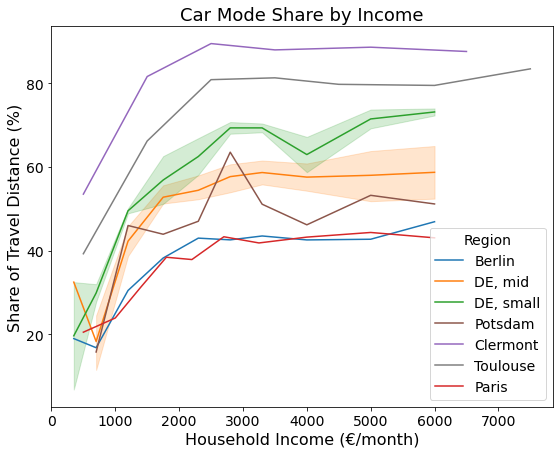

In [32]:
fig, ax = plt.subplots(figsize=(9,7))
sns.lineplot(ax=ax,x='Income', y='Car_ModeShare', data=inc, hue='Region2',alpha=1,palette=cp)
#sns.lineplot(ax=ax,x='Income', y='Car_ModeShare', data=inc.loc[~inc['City'].isin(['Paris','Berlin']),], hue='City',alpha=0.2,legend=False)
#handles, labels = plt.gca().get_legend_handles_labels()
# specify order
#order = [2, 3, 1, 0]
# pass handle & labels lists along with order as below
plt.legend(title='Region', fontsize=14,title_fontsize=14)
plt.title('Car Mode Share by Income',fontsize=18)
#plt.legend(title='Region', fontsize=14)
plt.xlabel('Household Income (€/month)',fontsize=16)
plt.ylabel('Share of Travel Distance (%)',fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)

plt.savefig('../figures/plots/All_CarModeShare_new.png',facecolor='w',dpi=65,bbox_inches='tight')


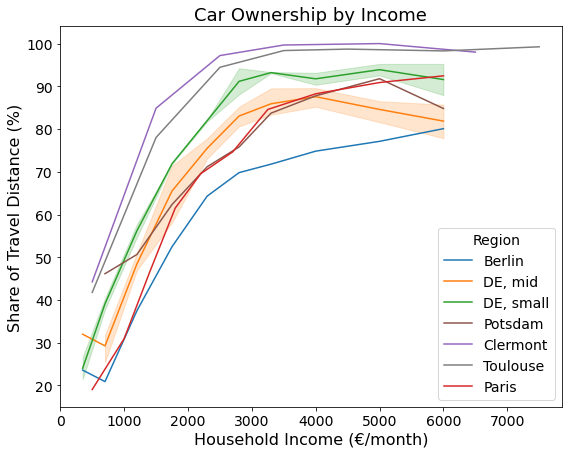

In [33]:
fig, ax = plt.subplots(figsize=(9,7))
sns.lineplot(ax=ax,x='Income', y='CarOwnershipHH', data=inc, hue='Region2',alpha=1,palette=cp)
#sns.lineplot(ax=ax,x='Income', y='Car_ModeShare', data=inc.loc[~inc['City'].isin(['Paris','Berlin']),], hue='City',alpha=0.2,legend=False)
#handles, labels = plt.gca().get_legend_handles_labels()
# specify order
#order = [2, 3, 1, 0]
# pass handle & labels lists along with order as below
plt.legend(title='Region', fontsize=14,title_fontsize=14)
plt.title('Car Ownership by Income',fontsize=18)
#plt.legend(title='Region', fontsize=14)
plt.xlabel('Household Income (€/month)',fontsize=16)
plt.ylabel('Share of Travel Distance (%)',fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.savefig('../figures/plots/All_CarOwnership_new.png',facecolor='w',dpi=65,bbox_inches='tight')
